<a href="https://colab.research.google.com/github/benihime91/tensorflow-keras-nbs/blob/master/tensorflow_example_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Albumentations with Tensorflow

**Author**: [Ayushman Buragohain](https://github.com/benihime91)

## Prepare the Google Colab environment

#### Download images

Download images that are used in the notebook and save to the `images` folder in the Colab environment.

In [1]:
!wget -q https://github.com/albumentations-team/albumentations_examples/archive/master.zip -O /tmp/albumentations_examples.zip
!unzip -o -qq /tmp/albumentations_examples.zip -d /tmp/albumentations_examples
!cp -r /tmp/albumentations_examples/albumentations_examples-master/notebooks/images .
!echo "Images are successfully downloaded"

Images are successfully downloaded


#### Install the latest version of Albumentations

Google Colab has an outdated version of Albumentations so we will install the latest stable version from PyPi.

In [2]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 952kB 11.2MB/s 
albumentations==0.4.6 is successfully installed


#### [Recommended] Update the version of tensorflow_datasets if you want to use it

- We'll we using an example from `tensorflow_datasets`.

In [3]:
! pip install --upgrade tensorflow_datasets

     |████████████████████████████████| 3.4MB 2.8MB/s 
  Found existing installation: tensorflow-datasets 2.1.0
    Uninstalling tensorflow-datasets-2.1.0:
      Successfully uninstalled tensorflow-datasets-2.1.0


## Run the example

In [4]:
# necessary imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from functools import partial
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
tfds.__version__

'3.2.1'

In [6]:
# load in the tf_flowers dataset
data, info= tfds.load(name="tf_flowers", split="train", as_supervised=True, with_info=True)
data

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

## An Example Pipeline Using `tf.image`

## Process Data

In [ ]:
def process_image(image, label, img_size):
    # cast and normalize image
    image = tf.image.convert_image_dtype(image, tf.float32)
    # apply simple augmentations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image,[img_size, img_size])
    return image, label

ds_tf = data.map(partial(process_image, img_size=120), num_parallel_calls=AUTOTUNE).batch(30).prefetch(AUTOTUNE)
ds_tf

<PrefetchDataset shapes: ((None, 120, 120, 3), (None,)), types: (tf.float32, tf.int64)>

## View images from the dataset

In [ ]:
def view_image(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()
    
    fig = plt.figure(figsize=(22, 22))
    for i in range(20):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"Label: {label[i]}")

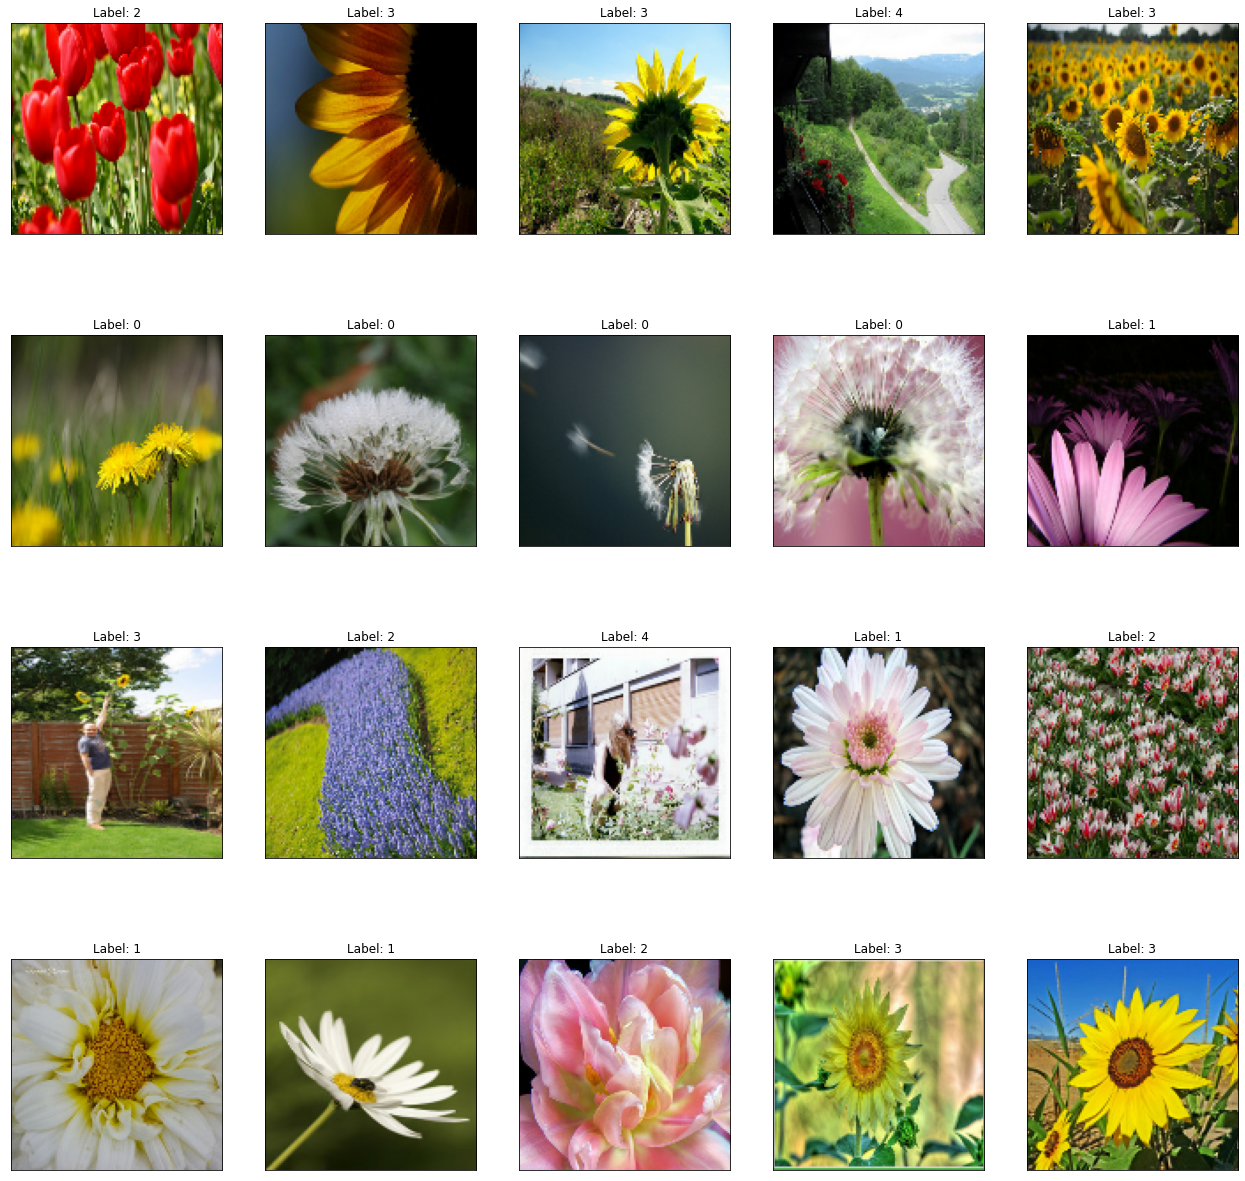

In [ ]:
view_image(ds_tf)

Using `tf.image` is very efficient to create a pipeline but the disadvantage is that with `tf.image` we can only apply limited amount of augmentations to out `input data`.
One way to solve is issue is to use `tf.keras` `ImageDataGenerator` class but `albumentations` is faster.

# An Example Pipeline using `albumentations`

To integrate `albumentations` into our tensorflow pipeline we can create two function :  
- Pipeline to apply `augmentation`.
- a function that calls the above function and passes in our data through the pipeline.
We can then wrap our 2nd Function under `tf.numpy_function` .

## Create Pipeline to Process data

In [ ]:
# Instantiate augments
# we can apply as many augments we want and adjust the values accordingly
# here I have chosen the augments and their arguments at random
transforms = Compose([
            Rotate(limit=40),
            RandomBrightness(limit=0.1),
            JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
            HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            RandomContrast(limit=0.2, p=0.5),
            HorizontalFlip(),
        ])

In [ ]:
def aug_fn(image, img_size):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    return aug_img

In [ ]:
def process_data(image, label, img_size):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img, label

In [ ]:
# create dataset
ds_alb = data.map(partial(process_data, img_size=120),
                  num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)
ds_alb

<PrefetchDataset shapes: (<unknown>, (None,)), types: (tf.float32, tf.int64)>

## View images from the dataset

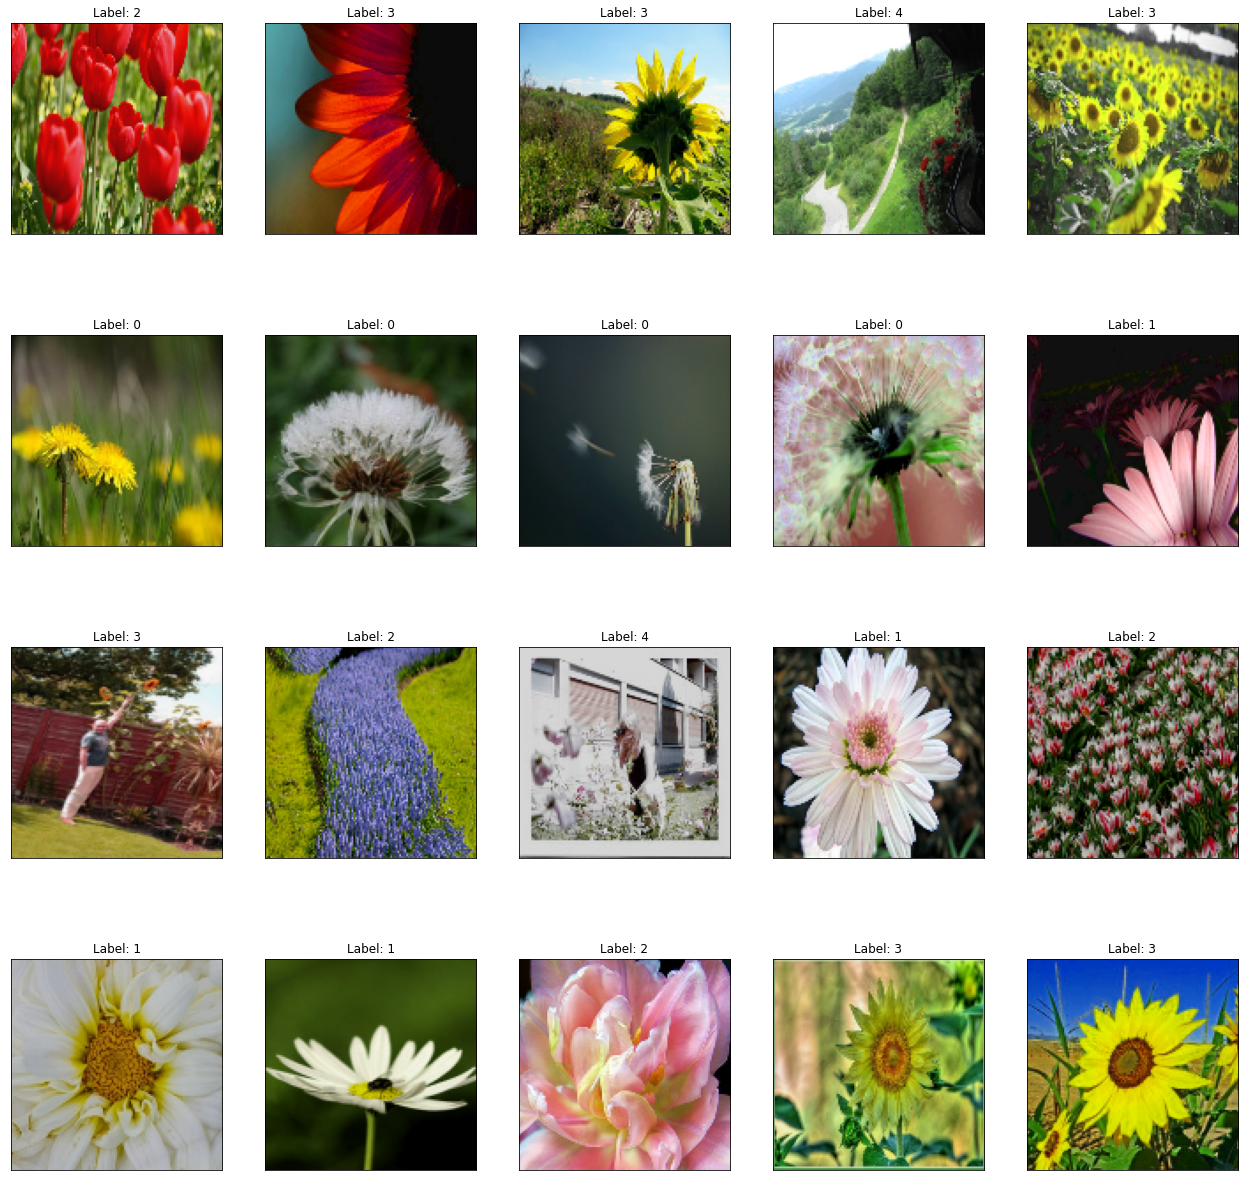

In [ ]:
view_image(ds_alb)

**We can then pass in this dataset to out model and call `fit` on our model**

## `Note`: 
Some `API's` of `tensorflow.keras.Model` might not work. Here's what we have tried so far : 

### What works :

In [ ]:
from tensorflow.keras import models, layers
from tensorflow import keras

# Running the Model in eager mode using Sequential API

def create_model(input_shape):
    return models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(5, activation='softmax')])
    
model = create_model((120,120,3))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy', run_eagerly=True)
model.fit(ds_alb, epochs=1)

115/115 [==============================] - 30s 259ms/step - loss: 1.3641 - accuracy: 0.4109


In [ ]:
# Functional API

input = keras.Input(shape=(120, 120, 3))
x = keras.layers.Conv2D(32, (3, 3), activation="relu")(input)
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dense(5, activation='softmax')(x)

model = keras.Model(inputs=input, outputs=x)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(ds_alb, epochs=1)

115/115 [==============================] - 22s 192ms/step - loss: 1.3935 - accuracy: 0.3929


In [ ]:
# Transfer Learning [freeze base model layers] sequential API

base_model = keras.applications.ResNet50(include_top=False, input_shape=(120, 120, 3), weights="imagenet")
base_model.trainable = False

model = keras.models.Sequential([
        base_model,
        keras.layers.Conv2D(32, (1, 1), activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(5, activation='softmax'),
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(ds_alb, epochs=1)

115/115 [==============================] - 29s 250ms/step - loss: 1.5379 - accuracy: 0.3185


In [ ]:
# Transfer Learning [unfreeze all layers] Sequential API

base_model = keras.applications.ResNet50(include_top=False, input_shape=(120, 120, 3), weights="imagenet")

model = keras.models.Sequential([
        base_model,
        keras.layers.Conv2D(32, (1, 1), activation="relu"),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(5, activation='softmax'),
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(ds_alb, epochs=1)

115/115 [==============================] - 48s 415ms/step - loss: 1.2079 - accuracy: 0.5796


In [ ]:
# Transfer learning with functional API

base_model = keras.applications.ResNet50(include_top=False, input_shape=(120, 120, 3), weights="imagenet")
base_model.trainable = False

input = keras.Input(shape=(120, 120, 3))
x = base_model(input, training=False)
x = keras.layers.Conv2D(32, (1, 1), activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dense(5, activation='softmax')(x)

model = keras.Model(inputs=input, outputs=x)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(ds_alb, epochs=1)

115/115 [==============================] - 31s 266ms/step - loss: 1.5364 - accuracy: 0.3134


In [ ]:
# Transfer Learning using subclassing API [freeze all layers of feature extractor]

base_model = keras.applications.ResNet50(include_top=False, input_shape=(120, 120, 3), weights="imagenet")
base_model.trainable = False

class MyModel(keras.Model):
    def __init__(self, base_model):
        super(MyModel, self).__init__()
        self.base = base_model
        self.layer_1 = keras.layers.Flatten()
        self.layer_2 = keras.layers.Dense(64, activation='relu')
        self.layer_3 = keras.layers.Dense(5, activation='softmax')

    def call(self, xb):
        x = self.base(xb)
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        return x


model = MyModel(base_model=base_model)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

model.fit(ds_alb, epochs=1)

115/115 [==============================] - 30s 265ms/step - loss: 1.5506 - accuracy: 0.3308


In [ ]:
# Transfer Learning using subclassing API [unfreeze all layers of feature extractor]

base_model = keras.applications.ResNet50(include_top=False, input_shape=(120, 120, 3), weights="imagenet")
base_model.trainable = True

class MyModel(keras.Model):
    def __init__(self, base_model):
        super(MyModel, self).__init__()
        self.base = base_model
        self.layer_1 = keras.layers.Flatten()
        self.layer_2 = keras.layers.Dense(64, activation='relu')
        self.layer_3 = keras.layers.Dense(5, activation='softmax')

    def call(self, xb):
        x = self.base(xb)
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        return x


model = MyModel(base_model=base_model)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

model.fit(ds_alb, epochs=1)

115/115 [==============================] - 47s 411ms/step - loss: 1.2741 - accuracy: 0.6158


### What won't work :

In [ ]:
# Using Sequential API without transfer learning & Eager Execution

def create_model(input_shape):
    return models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(5, activation='softmax')])
    
model = create_model((120,120,3))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(ds_alb, epochs=1)

ValueError: ignored

In [ ]:
# Using Subclass API without transfer learning & Eager Execution

class MyModel(keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu')
        self.pool1 = keras.layers.MaxPooling2D((2, 2))
        self.conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.pool2 = keras.layers.MaxPooling2D((2, 2))
        self.conv3 = keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.flat = keras.layers.Flatten()
        self.dense1 = keras.layers.Dense(64, activation='relu')
        self.dense2 = keras.layers.Dense(5, activation='softmax')

    def call(self, xb):
        x = self.conv1(xb)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.flat(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x


model = MyModel()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

model.fit(ds_alb, epochs=1)

ValueError: ignored